# Blame: ES or SNN?

This notebook contains three tasks for ES just to make sure it actaully works because it is apparently not working on SNN.

In [6]:
from EvolutionStrategy import ESParameter, ESModel

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

device = 'cuda'

## 1. Test on Trivial Loss Landscape

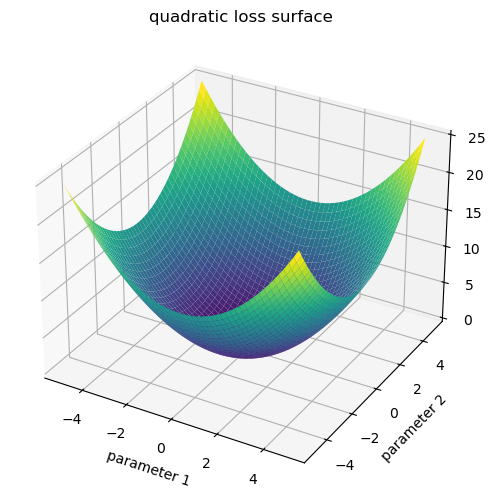

In [ ]:
def plot_landscape():
    # Create a meshgrid for X and Y
    x = np.linspace(-5, 5, 50)
    y = np.linspace(-5, 5, 50)
    X, Y = np.meshgrid(x, y)

    # Define a function for Z
    Z = (X**2 + Y**2) / 2

    # Create a figure and 3D axis
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Labels
    ax.set_xlabel('parameter 1')
    ax.set_ylabel('parameter 2')

    ax.set_title('quadratic loss surface')

    # Show the plot
    # plt.tight_layout()
    plt.show()
    
plot_landscape()

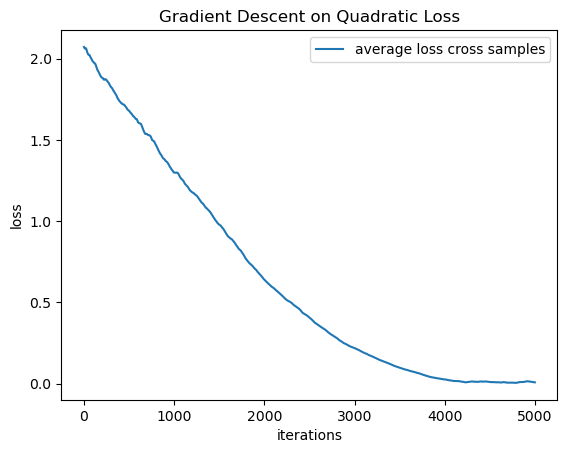

In [7]:
def quadratic_landscape(params):
    # params is of dimension: [nb_samples, ...params shape....]
    # so number of params is nubmer of elements in params shape
    nb_params = torch.numel(params[0])
    
    # the dimensions to sum are all but the first dim
    dims_to_sum = tuple(range(1, params.dim()))
    
    # normalize by number of parameters
    return torch.sum(params ** 2, dim=dims_to_sum) / nb_params 

def gradient_descent_for_dummy(param_to_loss):
    param_shape = [4,4]
    param_scale = 5
    param = ESParameter(para_means=torch.rand(param_shape).to(device) * param_scale, para_std=0.3, Optimizer=optim.Adam)
    
    
    average_loss_cross_samples = []
    for _ in range(5000):
        param_samples = param.sample(sample_size=30)        
        
        # loss shape: [nb_samples,]
        loss = param_to_loss(param_samples)
        
        param.gradient_descent(loss)
        average_loss_cross_samples.append(torch.mean(param.means).cpu())   
    
    plt.plot(average_loss_cross_samples, label='average loss cross samples')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.title('Gradient Descent on Quadratic Loss')
    plt.legend()
    plt.show()
    
gradient_descent_for_dummy(quadratic_landscape)

## 2. ES on CNN on MNIST

In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
def train_loop(es_model, dataloader, loss_fn, nb_model_samples = 30):
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        # keep track of stats for each model sample
        samples_loss = []
        correct = 0
        for model in es_model.samples(nb_model_samples):
            # Forward pass
            pred = model(x)
            samples_loss.append(loss_fn(pred, y))
            correct += (pred.argmax(1) == y).sum().item()
        samples_loss = torch.stack(samples_loss) 
        es_model.gradient_descent(samples_loss)
        
        print(f"loss: {samples_loss.mean():>7f}")
        
def test_loop(es_model, dataloader, loss_fn):
    model = es_model.get_best_model()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def train_cnn():
    train_dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                             transform=Compose([
                               ToTensor(),
                               Normalize((0.1307,), (0.3081,))
                             ])),
        batch_size=256, shuffle=True)

    test_dataloader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, download=True,
                                    transform=Compose([
                                    ToTensor(),
                                    Normalize((0.1307,), (0.3081,))
                                    ])),
        batch_size=1000, shuffle=True)
    with torch.no_grad():
        es_model = ESModel(Model=CNN, param_std=0.05, Optimizer=optim.Adam)
        for epoch in range(1, 100):
            print(f"Epoch {epoch}\n-------------------------------")
            # train the model
            train_loop(es_model,train_dataloader, nn.CrossEntropyLoss(), nb_model_samples=1000)
            test_loop(es_model, test_dataloader, nn.CrossEntropyLoss())
# train_cnn()

Observation:
- As I increase the std of parameters, the loss start to increase as well. When std = 1, the loss blows up. 
    - can i normalize layer to solve this problem? the output of each layer shouldn't be affected so much by the initialization of weights? Also, what makes this blow up (how does the weights work here)? 
- Adaptive STD ??!!! from large to small

## 3. Single Neuron Optimization Task

ES with SNN was a failure so we will try a simpler one parameter model mentioned in the ES paper. The task is to minimize number of spikes

In [ ]:
from EvolutionStrategy import ESModel
from Utilities import spike_count

from torch import optim
import wandb

class SingleNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.neuron = snn.Leaky(beta=0.85, learn_beta=False, threshold=0.5)
        self.i_app = torch.nn.parameter.Parameter(torch.tensor([2.,]),requires_grad=False)
    def forward(self):
        mem = self.neuron.init_leaky()
        spk_rec = []
        for _ in range(100):
            spk, mem = self.neuron(self.i_app, mem)    
            spk_rec.append(spk)
        return torch.stack(spk_rec, dim=0)        

def train_single_neuron():
    config = {
        'std': 1,
        'lr': 0.01,
        'nb_sample': 100,
        'epochs': 1000
    }
    
    with torch.no_grad(), wandb.init(entity = 'DarwinNeuron', project = 'SingleNeuron', name = 'name?', config = config) as run:
        es_model = ESModel(Model=SingleNeuron, param_std = run.config.std, Optimizer=optim.Adam, lr = run.config.lr)
        run.log({'I_app': es_model.get_best_model().i_app.item()})
        for epoch in range(1, run.config.epochs + 1):            
            losses = []
            for model in es_model.samples(run.config.nb_sample):
                spike_train = model()
                model_loss = spike_count(spike_train).float()
                losses.append(model_loss)
                
            losses = torch.stack(losses)
            es_model.gradient_descent(losses)
            run.log({'I_app': es_model.get_best_model().i_app.item(), 
                     'estimated_loss': ESModel.estimated_loss(losses),
                     'val_loss': spike_count(es_model.get_best_model().forward())})
            print(f"loss: {losses.mean():>7f}")
            
        return es_model.get_best_model()

# best_neuron = train_single_neuron()
            
            